In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Load the dataset
data = pd.read_csv('./csv/dummyData-3-seasonal_notAmerican.csv', header=None, names=['date', 'avail'])

In [3]:
# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Drop rows with invalid dates
data = data.dropna(subset=['date'])

# Sort the data by date
data = data.sort_values('date')

# Ensure 'avail' is numeric
data['avail'] = pd.to_numeric(data['avail'], errors='coerce')

# Drop rows with NaN in 'avail'
data = data.dropna(subset=['avail'])

/tmp/ipykernel_18039/4147684296.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


In [4]:
# Extract additional time features
data['month'] = data['date'].dt.month
data['day_of_year'] = data['date'].dt.dayofyear / 365.0
data['day_of_year'] = data['day_of_year'].apply(lambda x: round(x, 3))
data['year'] = data['date'].dt.year
data

,date,avail,month,day_of_year,year
0.0,2018-01-01,1,1,0.003,2018
1.0,2018-01-02,0,1,0.005,2018
2.0,2018-01-03,1,1,0.008,2018
3.0,2018-01-04,0,1,0.011,2018
4.0,2018-01-05,1,1,0.014,2018
...,...,...,...,...,...
2186.0,2023-12-27,0,12,0.989,2023
2187.0,2023-12-28,1,12,0.992,2023
2188.0,2023-12-29,0,12,0.995,2023
2189.0,2023-12-30,1,12,0.997,2023


In [5]:
# Normalize the 'avail' column
scaler = MinMaxScaler(feature_range=(0, 1))
data['avail'] = scaler.fit_transform(data[['avail']])

In [6]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:i + seq_length][['avail', 'day_of_year']].values
        y = data.iloc[i + seq_length]['avail']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
# Create sequences
sequence_length = 7
X, y = create_sequences(data, sequence_length)

In [7]:
X.size

30576

In [8]:
class AvailabilityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

dataset = AvailabilityDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, output_size=1, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

model = RNNModel()


In [10]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        # Forward pass
        outputs = model(X_batch)
        # print(outputs.squeeze())
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/1000], Loss: 0.2507
Epoch [20/1000], Loss: 0.2652
Epoch [30/1000], Loss: 0.3461
Epoch [40/1000], Loss: 0.1029
Epoch [50/1000], Loss: 0.2863
Epoch [60/1000], Loss: 0.5811
Epoch [70/1000], Loss: 0.1530
Epoch [80/1000], Loss: 0.4167
Epoch [90/1000], Loss: 0.2783
Epoch [100/1000], Loss: 0.1499
Epoch [110/1000], Loss: 0.2435
Epoch [120/1000], Loss: 0.3050
Epoch [130/1000], Loss: 0.1979
Epoch [140/1000], Loss: 0.2977
Epoch [150/1000], Loss: 0.1265
Epoch [160/1000], Loss: 0.2874
Epoch [170/1000], Loss: 0.1517
Epoch [180/1000], Loss: 0.3453
Epoch [190/1000], Loss: 0.5592
Epoch [200/1000], Loss: 0.3334
Epoch [210/1000], Loss: 0.3438
Epoch [220/1000], Loss: 0.0983
Epoch [230/1000], Loss: 0.2908
Epoch [240/1000], Loss: 0.1557
Epoch [250/1000], Loss: 0.1399
Epoch [260/1000], Loss: 0.0604
Epoch [270/1000], Loss: 0.2228
Epoch [280/1000], Loss: 0.0426
Epoch [290/1000], Loss: 0.1678
Epoch [300/1000], Loss: 0.6564
Epoch [310/1000], Loss: 0.2141
Epoch [320/1000], Loss: 0.1767
Epoch [330/1000],

In [11]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = torch.tensor(X, dtype=torch.float32)
        prediction = model(X)
        return prediction.item()

# Example usage
last_sequence = data.iloc[-sequence_length:][['avail', 'day_of_year']].values
next_day_avail = predict(model, last_sequence.reshape(1, sequence_length, 2))
print(last_sequence)
print(f'Predicted availability for the next day: {round(next_day_avail)}')


[[0.    0.984]
 [1.    0.986]
 [0.    0.989]
 [1.    0.992]
 [0.    0.995]
 [1.    0.997]
 [0.    1.   ]]
Predicted availability for the next day: 1


In [12]:
last_day = np.array([134,135,136,137,138,139,140]) / 365.0
last_day = np.round(last_day,3)
avail = np.array([0,1,0,1,0,1,0])
last_sequence= np.vstack(( avail,last_day)).T

In [13]:
print(last_sequence)

[[0.    0.367]
 [1.    0.37 ]
 [0.    0.373]
 [1.    0.375]
 [0.    0.378]
 [1.    0.381]
 [0.    0.384]]


In [14]:
next_day_avail = predict(model, last_sequence.reshape(1, sequence_length, 2))
print(last_sequence)
print(f'Predicted availability for the next day: {round(next_day_avail)}')

[[0.    0.367]
 [1.    0.37 ]
 [0.    0.373]
 [1.    0.375]
 [0.    0.378]
 [1.    0.381]
 [0.    0.384]]
Predicted availability for the next day: 1


In [15]:
torch.save(model,"./model/RNNmodelDummySet-4-Loss_%12.h5")

Text(0.5, 1.0, 'Availability over Time with Seasonal Bias (Dots)')

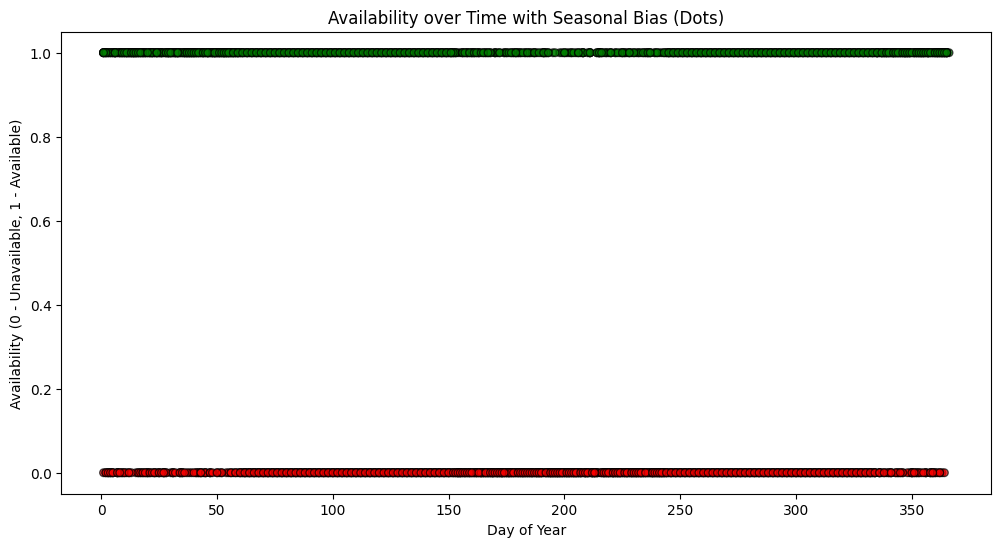

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime

dates = data['date']
dates = [date.date() for date in dates] 
avail = data['avail']

# Convert dates to numerical representation for plotting on x-axis
dates_numeric = [datetime.strptime(str(date), '%Y-%m-%d').timetuple().tm_yday for date in dates]  # Extract day of year

# Define colors based on availability
colors = ['green' if value == 1 else 'red' for value in avail]  # Green for 1, Red for 0

# Create the dot plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.scatter(dates_numeric, avail, c=colors, marker='o', s=30, alpha=0.7, edgecolors='black')  # Customize marker size and transparency

# Set axis labels and title
plt.xlabel('Day of Year')
plt.ylabel('Availability (0 - Unavailable, 1 - Available)')
plt.title('Availability over Time with Seasonal Bias (Dots)')

/tmp/ipykernel_16653/2690075250.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  dates = data["date"][:365]
/tmp/ipykernel_16653/2690075250.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  avail = data["avail"][:365]


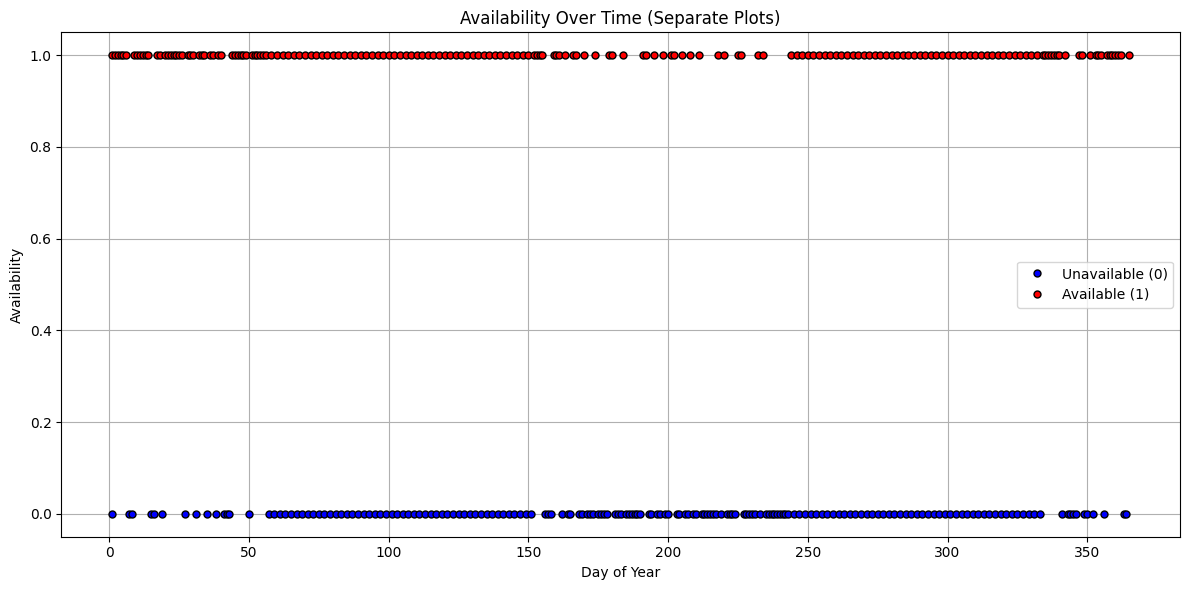

In [63]:
dates = data["date"][:365]
dates = [date.date() for date in dates] 
avail = data["avail"][:365]

# Convert dates to day of year
day_of_year = [datetime.strptime(str(date), '%Y-%m-%d').timetuple().tm_yday for date in dates]

# Separate data for plotting
data_0 = [day for day, value in zip(day_of_year, avail) if value == 0]
data_1 = [day for day, value in zip(day_of_year, avail) if value == 1]

# Define plot
plt.figure(figsize=(12, 6))

# Plot 0s (blue circles)
plt.plot(data_0, [0] * len(data_0), 'o', markersize=5, markerfacecolor='blue', markeredgewidth=1, markeredgecolor='black', label='Unavailable (0)')

# Plot 1s (red circles)
plt.plot(data_1, [1] * len(data_1), 'o', markersize=5, markerfacecolor='red', markeredgewidth=1, markeredgecolor='black', label='Available (1)')

# Set labels and title
plt.xlabel('Day of Year')
plt.ylabel('Availability')
plt.title('Availability Over Time (Separate Plots)')

# Add legend
plt.legend()

# Grid and tight layout
plt.grid(True)
plt.tight_layout()

# Display plot
plt.show()

# Testing

In [52]:
import datetime
import random

In [86]:
num_days = 7


def generate_random_sequence(num_days):
    """
  Generates a random sequence of 0 or 1 values for the specified number of days.
  """
    return np.array([random.randint(0, 1) for _ in range(num_days)])

today = datetime.date(2023, 6, 1)
# Generate random dates for the test data (optional)
# today = datetime.datetime.combine(today, datetime.time.min)
dates = np.round(np.array([
  int((today + datetime.timedelta(days=i)).strftime('%j')) # Apply dt.dayofyear here
  for i in range(num_days)
]) / 365.0, 3)



# Generate random availability data
availability = generate_random_sequence(num_days)



In [87]:
dates

array([0.416, 0.419, 0.422, 0.425, 0.427, 0.43 , 0.433])

In [88]:
last_sequence= np.vstack(( availability,dates)).T

In [89]:
next_day_avail = predict(model, last_sequence.reshape(1, sequence_length, 2))
print(last_sequence)
print(f'Predicted availability for the next day: {round(next_day_avail)}')

[[0.    0.416]
 [1.    0.419]
 [1.    0.422]
 [0.    0.425]
 [0.    0.427]
 [1.    0.43 ]
 [0.    0.433]]
Predicted availability for the next day: 1


In [7]:
load_model = torch.load("model/RNNmodelDummySet-4-Loss_%12-final.h5")

In [8]:
torch.save(load_model.state_dict(), "model/RNNmodelDummySet-4-Loss_%12-final_state.pt")